In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
import missingno as msno

In [34]:
train = pd.read_csv('/home/m.marzeta/ED/census-income.csv')
test = pd.read_csv('/home/m.marzeta/ED/census-income-test.csv')

In [35]:
print(train.describe())

                 age  detailed industry recode  detailed occupation recode  \
count  199523.000000             199523.000000               199523.000000   
mean       34.494199                 15.352320                   11.306556   
std        22.310895                 18.067129                   14.454204   
min         0.000000                  0.000000                    0.000000   
25%        15.000000                  0.000000                    0.000000   
50%        33.000000                  0.000000                    0.000000   
75%        50.000000                 33.000000                   26.000000   
max        90.000000                 51.000000                   46.000000   

       wage per hour  capital gains  capital losses  dividends from stocks  \
count  199523.000000   199523.00000   199523.000000          199523.000000   
mean       55.426908      434.71899       37.313788             197.529533   
std       274.896454     4697.53128      271.896428            

                 age  detailed industry recode  detailed occupation recode  \
count  199523.000000             199523.000000               199523.000000   
mean       34.494199                 15.352320                   11.306556   
std        22.310895                 18.067129                   14.454204   
min         0.000000                  0.000000                    0.000000   
25%        15.000000                  0.000000                    0.000000   
50%        33.000000                  0.000000                    0.000000   
75%        50.000000                 33.000000                   26.000000   
max        90.000000                 51.000000                   46.000000   

       wage per hour  capital gains  capital losses  dividends from stocks  \
count  199523.000000   199523.00000   199523.000000          199523.000000   
mean       55.426908      434.71899       37.313788             197.529533   
std       274.896454     4697.53128      271.896428            

In [36]:
train.shape, test.shape

((199523, 41), (99761, 42))

In [56]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.columns, len(numeric_features.columns), numeric_features

(Index(['age', 'detailed industry recode', 'detailed occupation recode',
        'wage per hour', 'capital gains', 'capital losses',
        'dividends from stocks', 'instance weight',
        'num persons worked for employer', 'own business or self employed',
        'veterans benefits', 'weeks worked in year', 'year'],
       dtype='object'),
 13,
         age  detailed industry recode  detailed occupation recode  \
 0        73                         0                           0   
 1        58                         4                          34   
 2        18                         0                           0   
 3         9                         0                           0   
 4        10                         0                           0   
 5        48                        40                          10   
 6        42                        34                           3   
 7        28                         4                          40   
 8        47      

In [38]:
categorical_features = train.select_dtypes(include=[np.object])
categorical_features.columns, len(categorical_features.columns)

(Index(['class of worker', 'education', 'enroll in edu inst last wk',
        'marital stat', 'major industry code', 'major occupation code', 'race',
        'hispanic origin', 'sex', 'member of a labor union',
        'reason for unemployment', 'full or part time employment stat',
        'tax filer stat', 'region of previous residence',
        'state of previous residence', 'detailed household and family stat',
        'detailed household summary in household',
        'migration code-change in msa', 'migration code-change in reg',
        'migration code-move within reg', 'live in this house 1 year ago',
        'migration prev res in sunbelt', 'famili members under 18',
        'country of birth father', 'country of birth mother',
        'country of birth self', 'citizenship',
        'fill inc questionnaire for veteran’s admin'],
       dtype='object'), 28)

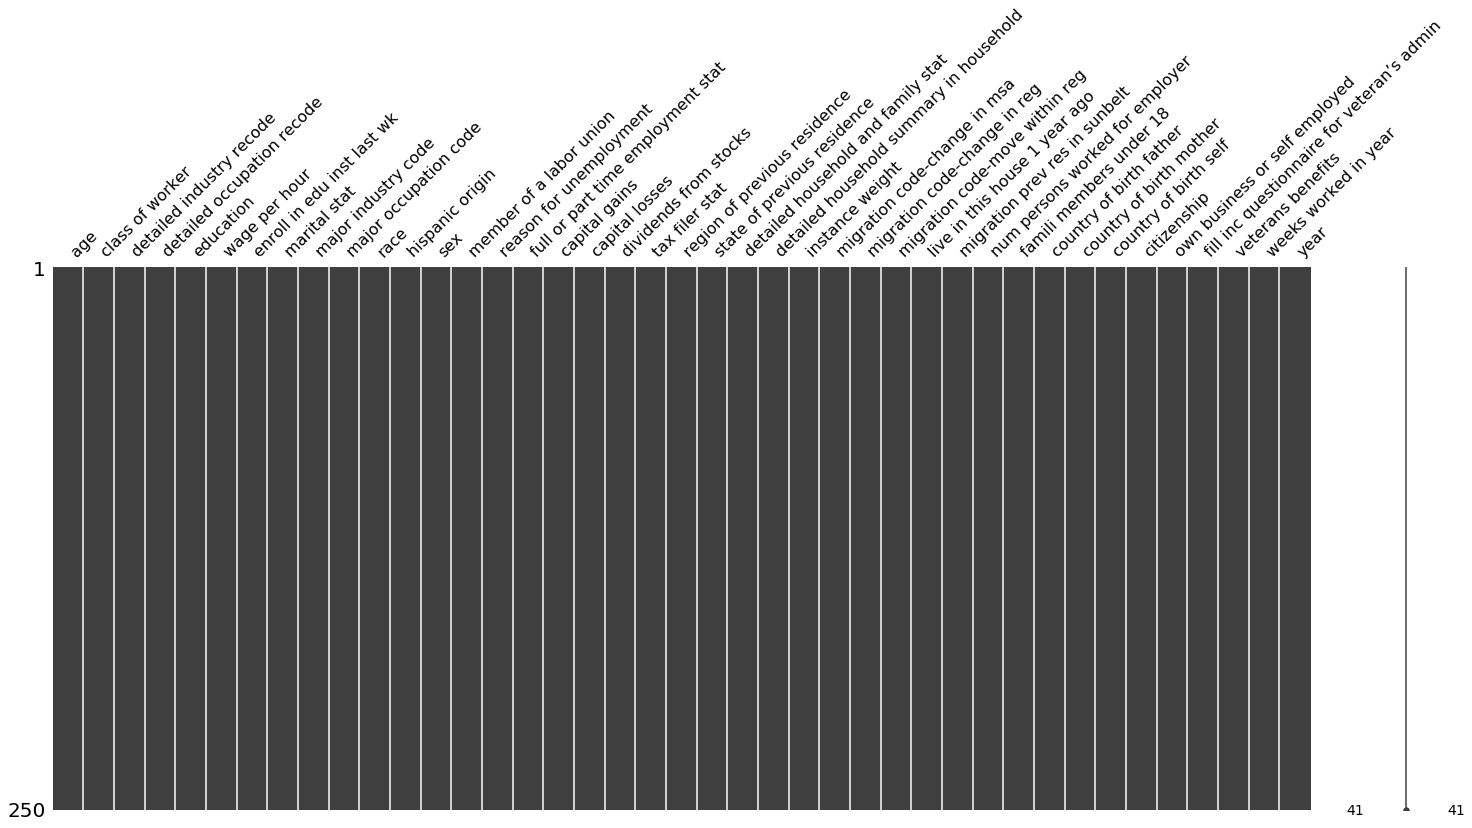

In [39]:
msno.matrix(train.sample(250))

ValueError: zero-size array to reduction operation minimum which has no identity

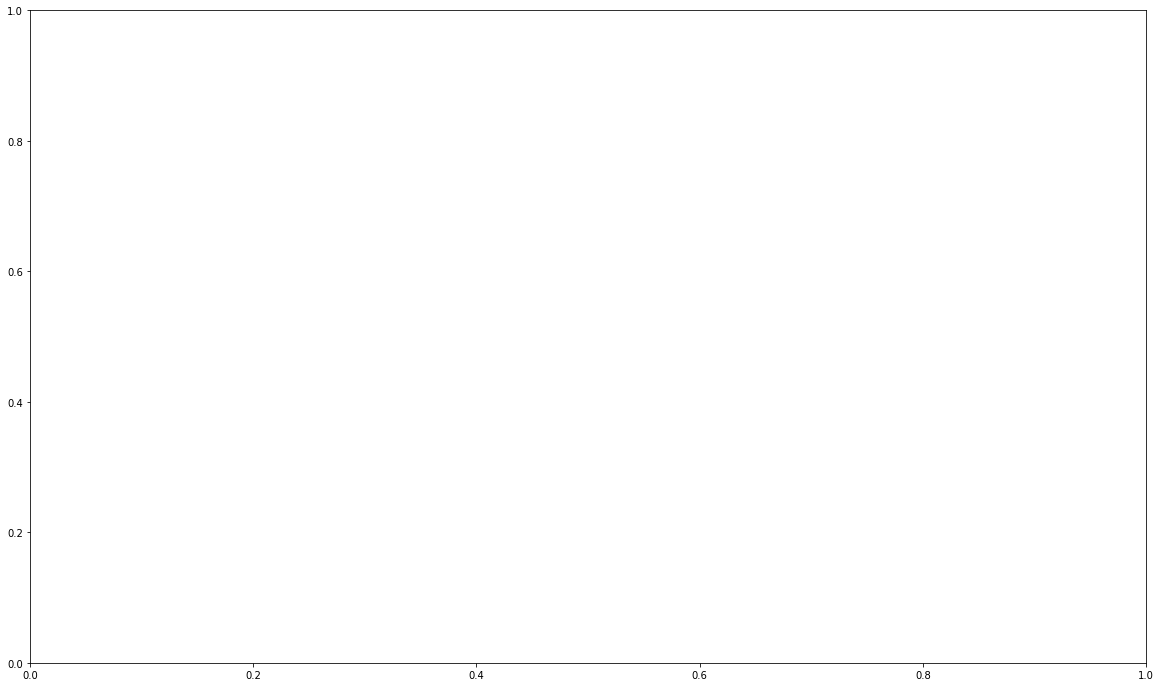

In [40]:
msno.heatmap(train)

In [41]:
train.skew(), train.kurt()

(age                                 0.373290
 detailed industry recode            0.516688
 detailed occupation recode          0.829238
 wage per hour                       8.935097
 capital gains                      18.990822
 capital losses                      7.632565
 dividends from stocks              27.786502
 instance weight                     1.432733
 num persons worked for employer     0.751561
 own business or self employed       2.912744
 veterans benefits                  -1.200994
 weeks worked in year                0.210169
 year                                0.001313
 dtype: float64, age                                  -0.732824
 detailed industry recode             -1.501108
 detailed occupation recode           -0.896533
 wage per hour                       155.218897
 capital gains                       393.062832
 capital losses                       61.632933
 dividends from stocks              1090.563754
 instance weight                       5.412514
 n

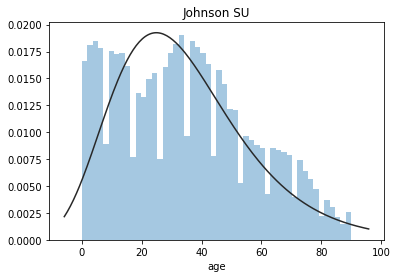

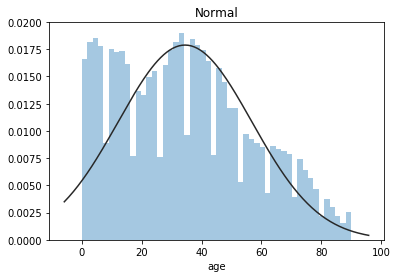

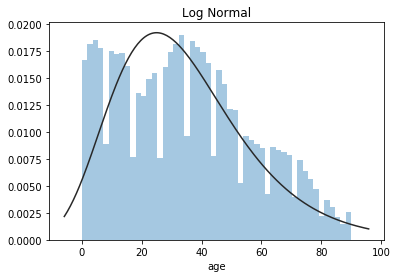

In [43]:
y = train['age']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

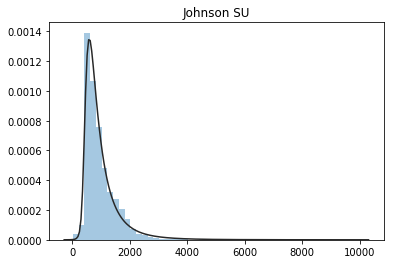

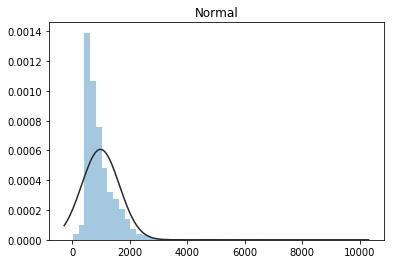

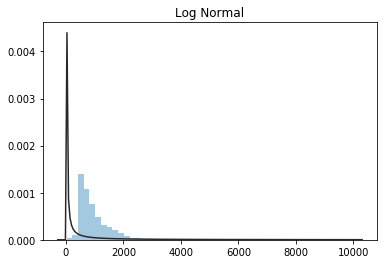

In [52]:
y = [t for t in train['wage per hour'] if t > 0] # rekordy gdzie nie ma zarobkow sa do bani
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

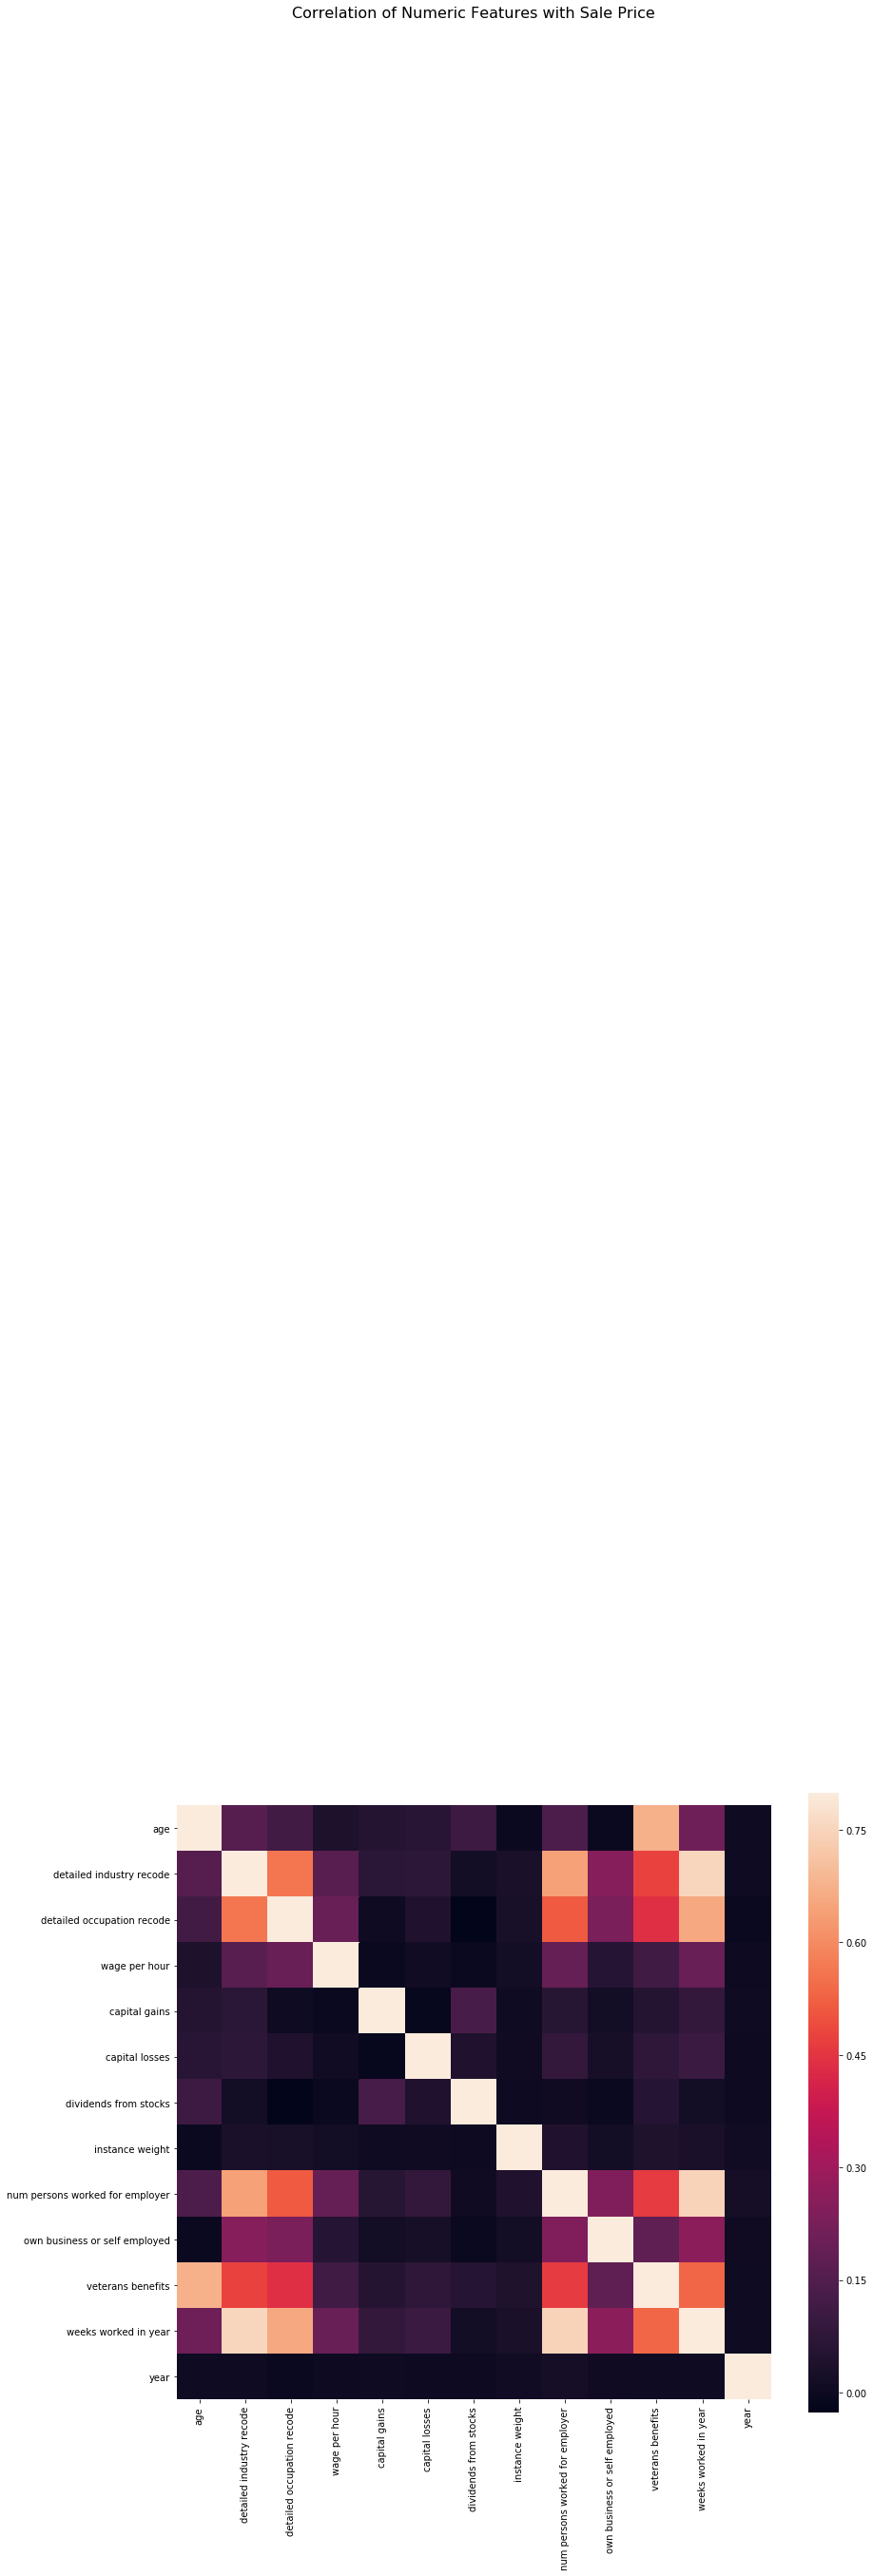

In [55]:
correlation = numeric_features.corr()
f , ax = plt.subplots(figsize = (14,12))

plt.title('Correlation of Numeric Features with Sale Price',y=1,size=16)

sns.heatmap(correlation,square = True,  vmax=0.8)